In [1]:
# Importing Necessary Libraries

import yfinance as yf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential

In [2]:
# Setting The Figsize Parameter For The Plots In This Notebook To Standardize The Size Of Plots

%matplotlib inline
rcParams["figure.figsize"] = 20, 10

In [3]:
# Downloading The Data

ticker = "MSFT"
df = yf.download(ticker, period = "10y")

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Checking The Dataset

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-08-18,44.939999,45.110001,44.680000,45.110001,38.330486,26891100
2014-08-19,44.970001,45.340000,44.830002,45.330002,38.758003,28139500
2014-08-20,45.340000,45.400002,44.900002,44.950001,38.433109,24770500
2014-08-21,44.840000,45.250000,44.830002,45.220001,38.663948,22285500
2014-08-22,45.349998,45.470001,45.070000,45.150002,38.604111,18294500


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-12,407.059998,408.760010,404.239990,406.809998,406.078064,16762900
2024-08-13,409.589996,414.950012,409.570007,414.010010,413.265137,19414300
2024-08-14,414.799988,417.720001,412.450012,416.859985,416.109985,18267000
2024-08-15,419.799988,421.109985,417.660004,421.029999,421.029999,20752100
2024-08-16,420.600006,421.339996,417.299988,418.470001,418.470001,22757000


In [6]:
# Checking The Number Of Rows And Columns In The Dataframe

df.shape

(2517, 6)

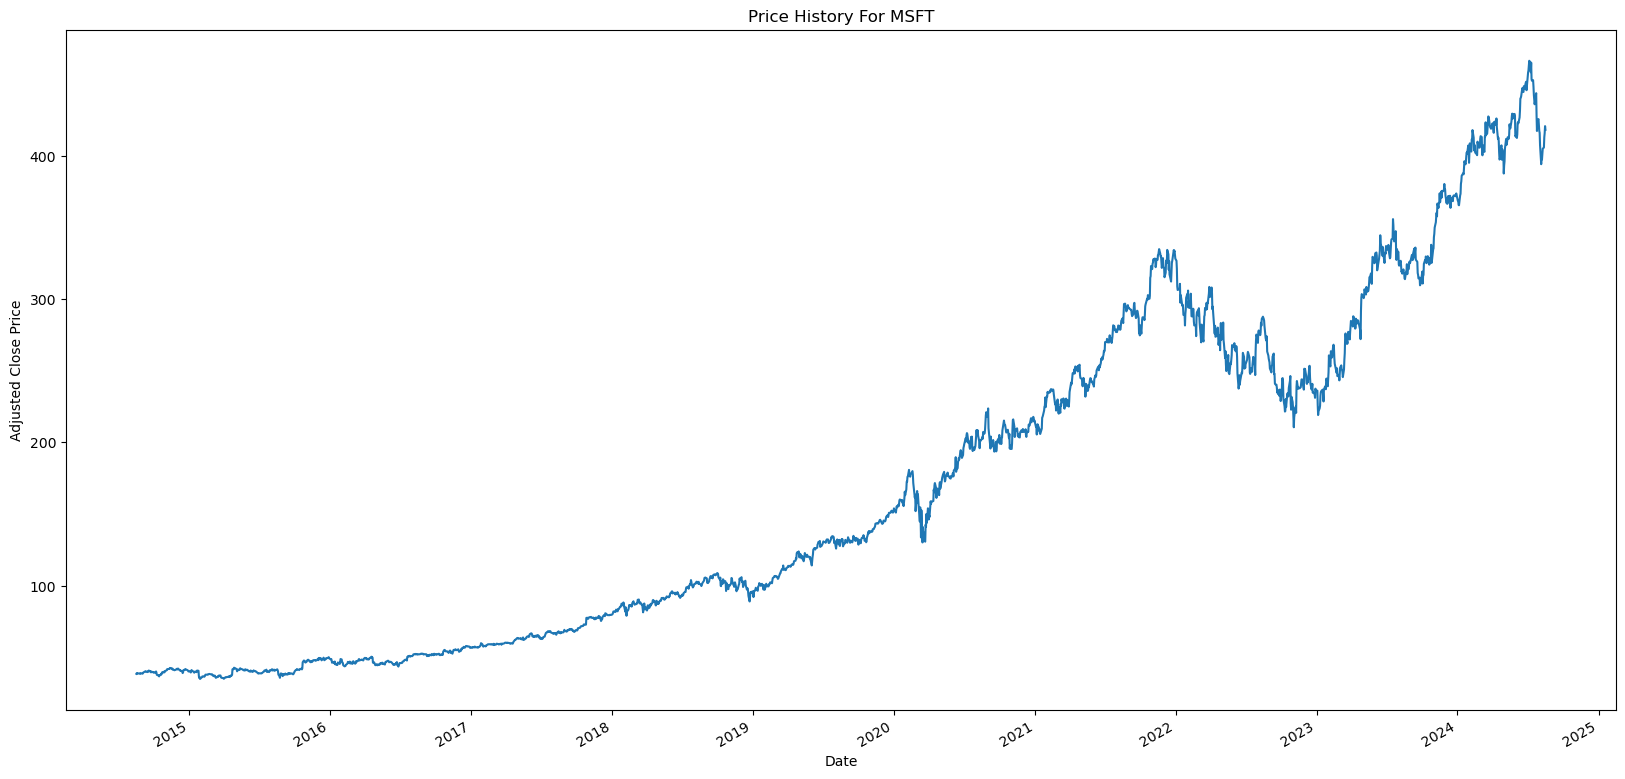

In [7]:
# Plotting The Adjusted Close Price

df["Adj Close"].plot()
plt.ylabel("Adjusted Close Price")
plt.title(f'Price History For {ticker}')
plt.show()

In [8]:
# Create A Dataframe With Just The Adj Close Prices

df1 = df["Adj Close"]

In [9]:
# Check The Filtered Dataset

df1.head()

Date
2014-08-18    38.330486
2014-08-19    38.758003
2014-08-20    38.433109
2014-08-21    38.663948
2014-08-22    38.604111
Name: Adj Close, dtype: float64

In [10]:
# Check The Number Of Rows And Columns In The Filtered Dataset 

df1.shape

(2517,)

In [11]:
# Rename The Column To Close For Convenience

df1.rename("Close", inplace=True)

Date
2014-08-18     38.330486
2014-08-19     38.758003
2014-08-20     38.433109
2014-08-21     38.663948
2014-08-22     38.604111
                 ...    
2024-08-12    406.078064
2024-08-13    413.265137
2024-08-14    416.109985
2024-08-15    421.029999
2024-08-16    418.470001
Name: Close, Length: 2517, dtype: float64

In [12]:
# Create An Array Called Prices With The Values Of All The Close Prices From The Filtered Dataframe

prices = df1.values

In [13]:
# Check The Prices Array

prices

array([ 38.3304863 ,  38.75800323,  38.43310928, ..., 416.10998535,
       421.02999878, 418.47000122])

In [14]:
# Normalize The Data To Values Between 0 And 1

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

In [15]:
# Computing The Number Of Records We Want In The Training Data Set

train_len = math.ceil(len(prices) * 0.8)
train_len

2014

In [16]:
# Create The Training Data Set With The First n Rows Of The Scaled Prices

train_data = scaled_prices[0:train_len, :]

In [17]:
# Create An Empty List For The Feature Data and Label Data

x_train, y_train = [], []

# Create A 60-Days Window Of Historical Prices (i-60) As Our Feature Data (x_train) And The Following 60-Days Window As Label Data (y_train)

for i in range(60, len(train_data)):
    x_train.append(scaled_prices[i-60:i, 0])
    y_train.append(scaled_prices[i, 0])

In [18]:
# Convert The x_train And y_train Into Numpy Arrays

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape Into A Three-Dimensional Array

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [19]:
test_data = scaled_prices[train_len-60:, :]
x_test = []
y_test = prices[train_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [20]:
#  Define A Sequential Model Which Consists Of A Linear Stack Of Layers

model = Sequential()

# Add A LSTM Layer By Giving It 100 Network Units

model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) # Set the return_sequence to true so that the output of the layer will be another sequence of the same length

# Add Another LSTM Layer With Also 100 Network Units 

model.add(LSTM(100, return_sequences=False)) # But we set the return_sequence to false for this time to only return the last output in the output sequence

# Add A Densely Connected Neural Network Layer With 25 Network Units

model.add(Dense(25))

# Add A Densely Connected Layer That Specifies The Output Of 1 Network Unit

model.add(Dense(1))

# Show The Summary Of Our LSTM Network Architecture

model.summary()

C:\Users\abhij\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - loss: 0.0012
Epoch 2/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 3.4864e-04
Epoch 3/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - loss: 3.1449e-04


In [22]:
# Apply The Model To Predict The Stock Prices Based On The Test Set

predictions = model.predict(x_test)

# Use The inverse_transform Method To Denormalize The Predicted Stock Prices

predictions = scaler.inverse_transform(predictions)

# Apply The RMSE Formula To Evaluate The Correctness Of The Predictions

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


5.032666094497468

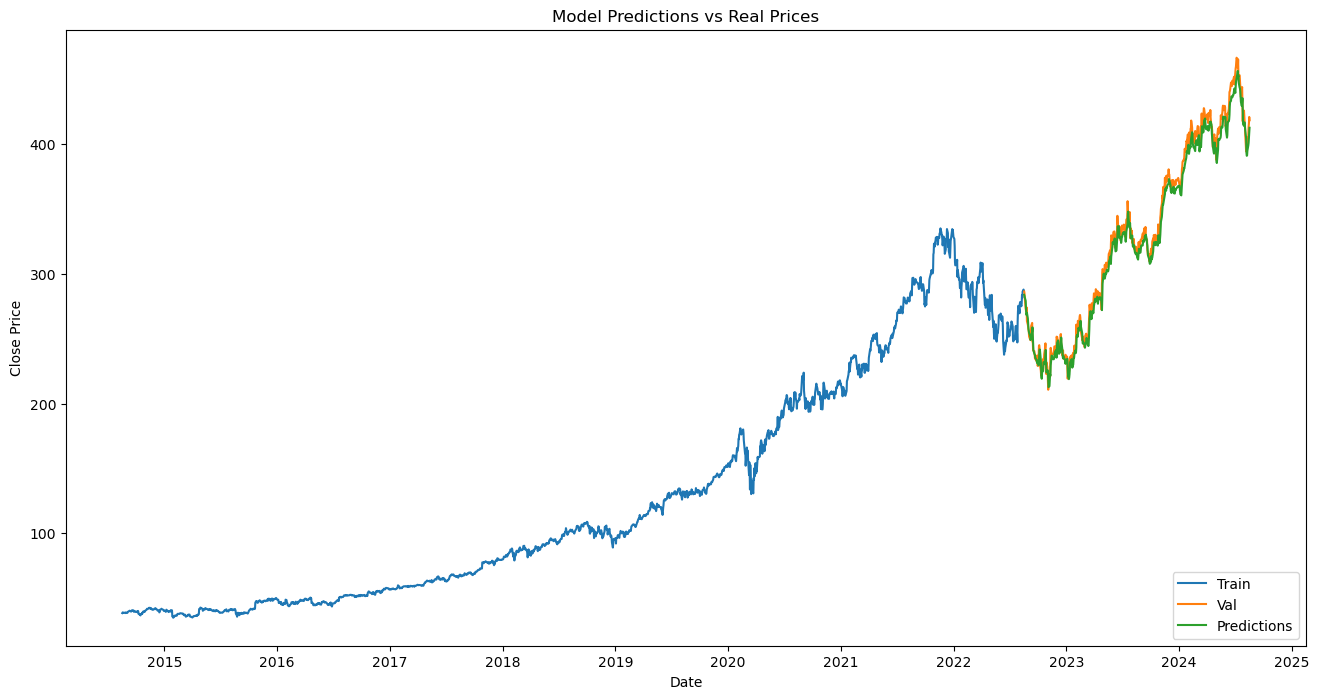

In [23]:
# Plotting The Model's Predictions Against The Actual Prices Of A Stock

data = df.filter(['Adj Close'])
train = data[:train_len].copy()
validation = data[train_len:].copy()
validation['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

You can observe that LSTM has predicted stocks almost similar to actual stocks.